<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

# Exploring the Effects of Perturbations on Saliency Map Generation

The link between saliency maps and model natural robustness is currently unclear. This is a simple notebook exploring how perturbations might affect saliency maps, using tools provided by the `nrtk` and `xaitk-saliency` packages.

## Table of Contents
* [Environment Setup](#environment-setup)
* [Example Images](#example-images)
* [Defining the "Application"](#defining-the-application)
* [Running the "Application"](#running-the-application)
    * [Classifier](#classifier)
    * [Saliency Generator](#saliency-generator)
    * [Results](#results)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/maite/jatic-perturbations-saliency.ipynb)


## Set Up the Environment <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
from __future__ import annotations

import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing xaitk-jatic...")
!{sys.executable} -m pip install -q xaitk-jatic
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets>=3.4.0
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing tabulate...")
!{sys.executable} -m pip install -q tabulate
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing nrtk[pybsm,headless]...")
!{sys.executable} -m pip install -q nrtk[pybsm,headless]

print("Done!")

Installing xaitk-jatic...


Installing Hugging Face datasets...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.4.14 requires opencv-python>=4.6.0, which is not installed.


Installing Hugging Face transformers...


Installing tabulate...


Installing torch...


Installing nrtk[pybsm,headless]...


Done!


In [2]:
import warnings
from collections.abc import Hashable, Sequence
from dataclasses import dataclass, field
from typing import TYPE_CHECKING, Any

import maite.protocols.image_classification as ic
import numpy as np
import torch
from datasets import Dataset, load_dataset
from matplotlib import pyplot as plt
from scipy.stats import entropy
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from tabulate import tabulate
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
)
from xaitk_jatic.interop.image_classification.model import JATICImageClassifier
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import (
    GenerateImageClassifierBlackboxSaliency,
)

from nrtk.impls.perturb_image.optical.otf import JitterPerturber

warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations

./.tox/papermill/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./.tox/papermill/lib/python3.10/site-packages/xaitk_saliency/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Example Images <a name="example-images"></a>

We'll use example images from the CIFAR-10 test dataset, but this could be expanded to many images -- even across a dataset.

In [3]:
data = load_dataset("cifar10", split="test")

if TYPE_CHECKING:
    assert isinstance(data, Dataset)

labels = data.features["label"].names
data.set_transform(lambda x: {"image": x["img"], "label": x["label"]})

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating train split:  58%|█████▊    | 28800/50000 [00:00<00:00, 286253.80 examples/s]

Generating train split: 100%|██████████| 50000/50000 [00:00<00:00, 332659.50 examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 378397.03 examples/s]

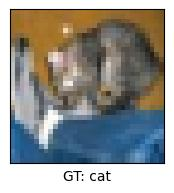

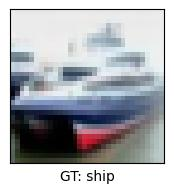

In [4]:
num_samples = 2
if TYPE_CHECKING:
    assert isinstance(data, Dataset)
imgs = np.asarray([np.asarray(data[idx]["image"]) for idx in range(num_samples)])
ground_truth: list[int] = [data[idx]["label"] for idx in range(num_samples)]

for img, gt in zip(imgs, ground_truth, strict=False):
    plt.figure(figsize=(2, 2))
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(f"GT: {labels[gt]}")
    _ = plt.imshow(img)

## Defining the "Application" <a name="defining-the-application"></a>

First we'll define a couple of dataclasses to keep track of results more easily:

In [5]:
@dataclass
class PerturbationResult:
    """Dataclass for storing perturbed image and associated results."""

    descriptor: str
    img: np.ndarray
    sal_maps: np.ndarray
    pred_class: int
    pred_prob: float


@dataclass
class SaliencyResults:
    """Dataclass for storing saliency map and associated results."""

    ref_img: np.ndarray
    ref_sal_maps: np.ndarray
    gt: int
    pred_class: int
    pred_prob: float
    perturbations: list[PerturbationResult] = field(default_factory=list)

Next, we'll define a function to compute specified metrics upon our saliency map results. These metrics include measures such as the entropy of the resulting saliency map, as well as various measures of correlation between the saliency map computed on the original image and the saliency maps computed on perturbed images.

In [6]:
def _compute_entropy(
    sal_map: np.ndarray,
    clip_min: int | None = None,
    clip_max: int | None = None,
) -> np.number | np.ndarray:
    if clip_min is not None or clip_max is not None:
        s = np.clip(sal_map, clip_min, clip_max)
    else:
        s = (sal_map - sal_map.min()) / (sal_map.max() - sal_map.min())
    return entropy(s.ravel(), base=2)


def _compute_ssd(sal_map: np.ndarray, ref_sal_map: np.ndarray) -> float:
    sum_sq_diff = np.sum(np.power(np.subtract(sal_map, ref_sal_map), 2))
    norm = np.sqrt(np.sum(np.power(sal_map, 2)) * np.sum(np.power(ref_sal_map, 2)))
    if not norm:
        return np.inf
    return sum_sq_diff / norm


def _compute_xcorr(sal_map: np.ndarray, ref_sal_map: np.ndarray) -> float:
    def _normalize(s: np.ndarray) -> tuple[np.ndarray, bool]:
        s -= s.mean()
        std = s.std()

        if std:
            s /= std

        return s, std == 0

    s1, c1 = _normalize(sal_map.copy())
    s2, c2 = _normalize(ref_sal_map.copy())

    if c1 and not c2:
        return 0.0
    return np.corrcoef(s1.flatten(), s2.flatten())[0, 1]


def _compute_metric(sal_map: np.ndarray, ref_sal_map: np.ndarray, m: str) -> float:
    if "entropy" in m:
        _compute_entropy_setup(sal_map, m)
    if m == "ssd":
        return _compute_ssd(sal_map, ref_sal_map)
    if m == "xcorr":
        return _compute_xcorr(sal_map, ref_sal_map)
    return np.nan


def _compute_entropy_setup(sal_map: np.ndarray, m: str) -> float | np.number | np.ndarray:
    if m == "entropy":
        return _compute_entropy(sal_map)
    if m == "pos saliency entropy":
        return _compute_entropy(sal_map, 0, 1)
    if m == "neg saliency entropy":
        return _compute_entropy(sal_map, -1, 0)
    return np.nan


def _generate_row(
    sal_map: np.ndarray,
    ref_sal_map: np.ndarray,
    row_label: str,
    metrics: tuple[str, ...],
) -> list[Hashable]:
    r: list[Hashable] = [row_label]

    r.extend([_compute_metric(sal_map, ref_sal_map, metric.lower().strip()) for metric in metrics])

    return r


def compute_metrics(results: list[SaliencyResults], metrics: tuple[str, ...]) -> None:
    """Compute metrics for saliency maps."""
    headers = ["Perturbation"]
    headers.extend(list(metrics))
    for res in results:
        rows = []

        rows.append(_generate_row(res.ref_sal_maps[res.gt], res.ref_sal_maps[res.gt], "Ref Image", metrics))
        rows.extend(
            [
                _generate_row(pert.sal_maps[res.gt], res.ref_sal_maps[res.gt], f"{pert.descriptor}", metrics)
                for pert in res.perturbations
            ],
        )

        print(tabulate(rows, headers=headers, tablefmt="plain"))

We'll also define a function to display all generated saliency maps.

In [7]:
def _plot_img(img: np.ndarray, num_cols: int, descriptor: str = "") -> None:
    plt.subplot(2, num_cols, 1)
    plt.imshow(img, cmap="gray")
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(descriptor)


def _plot_rows(sal_maps: np.ndarray, num_cols: int, plot_idxes: list[int] | None = None) -> None:
    plot_idxes = list(range(len(sal_maps))) if plot_idxes is None else [*set(plot_idxes)]
    n_cols = min(num_cols - 1, len(plot_idxes))
    n_rows = 2

    num_imgs = 0
    for r in range(n_rows):
        col_offset = 2
        if r > 0:
            col_offset = 3
        for c in range(r * n_cols, min(r * n_cols + n_cols, len(plot_idxes))):
            plt.subplot(n_rows, num_cols, c + col_offset)
            im = plt.imshow(sal_maps[plot_idxes[c]], cmap=plt.get_cmap("RdBu"), vmin=-1, vmax=1)
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"{labels[plot_idxes[c]]}")
            num_imgs += 1

            if num_imgs == len(plot_idxes):
                fig = plt.gcf()
                cax = fig.add_axes((0.38, 0.60, 0.01, 0.21))  # tweaked for this particular example
                plt.colorbar(im, cax=cax)


def display_results(results: list[SaliencyResults], labels: dict[int, str]) -> None:
    """Displays saliency results with plots and a table."""
    num_classes = len(labels)

    for res in results:
        plt.figure(figsize=(10, 5))
        num_cols = np.ceil(num_classes / 2).astype(int) + 1
        pred = f"{labels[res.pred_class]} ({res.pred_prob:.2f})"
        _plot_img(res.ref_img, num_cols, f"Ref Img\nGT: {labels[res.gt]}\nPred: {pred}")
        _plot_rows(res.ref_sal_maps, num_cols, [res.gt])

        for pert in res.perturbations:
            plt.figure(figsize=(10, 5))
            pred = f"{pert.pred_class} ({pert.pred_prob:.2f})"
            _plot_img(pert.img, num_cols, f"{pert.descriptor}\nPred: {pred}")
            _plot_rows(pert.sal_maps, num_cols, [res.gt])

    plt.show()

Finally, we'll define the "application", which perturbs the given input image(s) to varying degrees and generates saliency maps. In this case, we'll perturb the images using a pyBSM based perturber. To easily apply this perturbation, we'll use the `JitterPerturber`, which simulates varying amounts of sensor jitter on image collection.

In [8]:
def _max_class(probs: dict) -> str:
    v = list(probs.values())
    k = list(probs.keys())
    return k[v.index(max(v))]


def _generate_augmented_maps(
    idx: int,
    kwargs: list[dict[str, Any]],
    res: SaliencyResults,
    img: np.ndarray,
    num_images: int,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
) -> None:
    for k in kwargs:
        print(f"Generating saliency maps for s_y={k['s_y']} (ref image {idx + 1} of {num_images})")
        xform = JitterPerturber(**k)
        img_out, _ = xform(image=np.copy(img))
        sal_maps = saliency_generator(img_out, image_classifier)
        probs = next(image_classifier.classify_images(np.expand_dims(img_out, axis=0)))
        pred_class = _max_class(probs)

        pert = PerturbationResult(
            descriptor=f"ksize={k}",
            img=img_out,
            sal_maps=sal_maps,
            pred_class=labels[pred_class],
            pred_prob=probs[pred_class],
        )

        res.perturbations.append(pert)


def generate_perturbed_sal_maps(
    images: np.ndarray,
    ground_truth: list[int],
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
    kwargs: list[dict[str, Any]],
    display_labels: dict[int, str],
    display_maps: bool = True,
    metrics: tuple[str, ...] = ("Pos Saliency Entropy", "Neg Saliency Entropy", "Entropy", "SSD", "XCorr"),
) -> list[SaliencyResults]:
    """Generate saliency maps for image."""
    # Get class labels
    labels = image_classifier.get_labels()

    # Generate saliency maps
    results = []
    for idx, img in enumerate(images):
        print(f"Generating saliency maps for reference image (image {idx + 1} of {len(images)})")
        sal_maps = saliency_generator(img, image_classifier)
        probs = next(image_classifier.classify_images(np.expand_dims(img, axis=0)))
        pred_class = _max_class(probs)
        res = SaliencyResults(
            ref_img=np.copy(img),
            ref_sal_maps=sal_maps,
            gt=ground_truth[idx],
            pred_class=labels.index(pred_class),
            pred_prob=probs[pred_class],
        )

        _generate_augmented_maps(idx, kwargs, res, img, len(images), image_classifier, saliency_generator)

        results.append(res)

    for result in results:
        # Plot each image in set with saliency maps
        if display_maps:
            display_results([result], display_labels)

        # Compute metrics
        compute_metrics([result], metrics)

    return results

## Running the "Application" <a name="running-the-application"></a>

### Classifier <a name="classifier"></a>

We'll use a Hugging Face model conforming to the `maite` image classification protocol, along with the relevant `xaitk-saliency` adapter.

In [9]:
class HuggingFaceClassifier:
    """MAITE wrapper for HuggingFaceClassifier."""

    def __init__(self, model_name: str, device: str) -> None:
        """Initialize HuggingFaceClassifier."""
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)
        self.device = device

        self.model.eval()
        self.model.to(device)
        self.metadata = self.model.config.id2label

    def __call__(self, batch: Sequence[ic.InputType]) -> Sequence[ic.TargetType]:
        """Run classifier for batch and return results."""
        # tensor bridging
        input_tensor = torch.as_tensor(batch)
        if input_tensor.ndim != 4:
            raise ValueError(f"Invalid input dimensions. Expected 4, got {input_tensor.ndim}")

        # preprocess
        hf_inputs = self.image_processor(input_tensor, return_tensors="pt")

        # put on device
        hf_inputs = hf_inputs.to(self.device)

        # get predictions
        with torch.no_grad():
            return self.model(**hf_inputs).logits.softmax(1).detach().cpu()


jatic_classifier: ic.Model = HuggingFaceClassifier(
    model_name="aaraki/vit-base-patch16-224-in21k-finetuned-cifar10",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Loading weights:   0%|          | 1/200 [00:00<00:00, 39945.75it/s, Materializing param=classifier.bias]

Loading weights:   0%|          | 1/200 [00:00<00:00, 2839.75it/s, Materializing param=classifier.bias] 

Loading weights:   1%|          | 2/200 [00:00<00:00, 1970.54it/s, Materializing param=classifier.weight]

Loading weights:   1%|          | 2/200 [00:00<00:00, 1447.56it/s, Materializing param=classifier.weight]

Loading weights:   2%|▏         | 3/200 [00:00<00:00, 1496.18it/s, Materializing param=vit.embeddings.cls_token]

Loading weights:   2%|▏         | 3/200 [00:00<00:00, 1276.03it/s, Materializing param=vit.embeddings.cls_token]

Loading weights:   2%|▏         | 4/200 [00:00<00:00, 1393.23it/s, Materializing param=vit.embeddings.patch_embeddings.projection.bias]

Loading weights:   2%|▏         | 4/200 [00:00<00:00, 1181.58it/s, Materializing param=vit.embeddings.patch_embeddings.projection.bias]

Loading weights:   2%|▎         | 5/200 [00:00<00:00, 1290.63it/s, Materializing param=vit.embeddings.patch_embeddings.projection.weight]

Loading weights:   2%|▎         | 5/200 [00:00<00:00, 1079.61it/s, Materializing param=vit.embeddings.patch_embeddings.projection.weight]

Loading weights:   3%|▎         | 6/200 [00:00<00:00, 1174.27it/s, Materializing param=vit.embeddings.position_embeddings]               

Loading weights:   3%|▎         | 6/200 [00:00<00:00, 1104.49it/s, Materializing param=vit.embeddings.position_embeddings]

Loading weights:   4%|▎         | 7/200 [00:00<00:00, 1212.58it/s, Materializing param=vit.encoder.layer.0.attention.attention.key.bias]

Loading weights:   4%|▎         | 7/200 [00:00<00:00, 1152.78it/s, Materializing param=vit.encoder.layer.0.attention.attention.key.bias]

Loading weights:   4%|▍         | 8/200 [00:00<00:00, 1244.65it/s, Materializing param=vit.encoder.layer.0.attention.attention.key.weight]

Loading weights:   4%|▍         | 8/200 [00:00<00:00, 1192.79it/s, Materializing param=vit.encoder.layer.0.attention.attention.key.weight]

Loading weights:   4%|▍         | 9/200 [00:00<00:00, 1274.95it/s, Materializing param=vit.encoder.layer.0.attention.attention.query.bias]

Loading weights:   4%|▍         | 9/200 [00:00<00:00, 1225.69it/s, Materializing param=vit.encoder.layer.0.attention.attention.query.bias]

Loading weights:   5%|▌         | 10/200 [00:00<00:00, 1304.28it/s, Materializing param=vit.encoder.layer.0.attention.attention.query.weight]

Loading weights:   5%|▌         | 10/200 [00:00<00:00, 1260.16it/s, Materializing param=vit.encoder.layer.0.attention.attention.query.weight]

Loading weights:   6%|▌         | 11/200 [00:00<00:00, 1330.91it/s, Materializing param=vit.encoder.layer.0.attention.attention.value.bias]  

Loading weights:   6%|▌         | 11/200 [00:00<00:00, 1286.52it/s, Materializing param=vit.encoder.layer.0.attention.attention.value.bias]

Loading weights:   6%|▌         | 12/200 [00:00<00:00, 1351.84it/s, Materializing param=vit.encoder.layer.0.attention.attention.value.weight]

Loading weights:   6%|▌         | 12/200 [00:00<00:00, 1309.29it/s, Materializing param=vit.encoder.layer.0.attention.attention.value.weight]

Loading weights:   6%|▋         | 13/200 [00:00<00:00, 1366.50it/s, Materializing param=vit.encoder.layer.0.attention.output.dense.bias]     

Loading weights:   6%|▋         | 13/200 [00:00<00:00, 1326.50it/s, Materializing param=vit.encoder.layer.0.attention.output.dense.bias]

Loading weights:   7%|▋         | 14/200 [00:00<00:00, 1378.05it/s, Materializing param=vit.encoder.layer.0.attention.output.dense.weight]

Loading weights:   7%|▋         | 14/200 [00:00<00:00, 1341.04it/s, Materializing param=vit.encoder.layer.0.attention.output.dense.weight]

Loading weights:   8%|▊         | 15/200 [00:00<00:00, 1390.32it/s, Materializing param=vit.encoder.layer.0.intermediate.dense.bias]      

Loading weights:   8%|▊         | 15/200 [00:00<00:00, 1353.00it/s, Materializing param=vit.encoder.layer.0.intermediate.dense.bias]

Loading weights:   8%|▊         | 16/200 [00:00<00:00, 1401.34it/s, Materializing param=vit.encoder.layer.0.intermediate.dense.weight]

Loading weights:   8%|▊         | 16/200 [00:00<00:00, 1368.65it/s, Materializing param=vit.encoder.layer.0.intermediate.dense.weight]

Loading weights:   8%|▊         | 17/200 [00:00<00:00, 1411.25it/s, Materializing param=vit.encoder.layer.0.layernorm_after.bias]     

Loading weights:   8%|▊         | 17/200 [00:00<00:00, 1380.64it/s, Materializing param=vit.encoder.layer.0.layernorm_after.bias]

Loading weights:   9%|▉         | 18/200 [00:00<00:00, 1423.22it/s, Materializing param=vit.encoder.layer.0.layernorm_after.weight]

Loading weights:   9%|▉         | 18/200 [00:00<00:00, 1392.45it/s, Materializing param=vit.encoder.layer.0.layernorm_after.weight]

Loading weights:  10%|▉         | 19/200 [00:00<00:00, 1426.02it/s, Materializing param=vit.encoder.layer.0.layernorm_before.bias] 

Loading weights:  10%|▉         | 19/200 [00:00<00:00, 1397.51it/s, Materializing param=vit.encoder.layer.0.layernorm_before.bias]

Loading weights:  10%|█         | 20/200 [00:00<00:00, 1436.85it/s, Materializing param=vit.encoder.layer.0.layernorm_before.weight]

Loading weights:  10%|█         | 20/200 [00:00<00:00, 1406.82it/s, Materializing param=vit.encoder.layer.0.layernorm_before.weight]

Loading weights:  10%|█         | 21/200 [00:00<00:00, 1443.92it/s, Materializing param=vit.encoder.layer.0.output.dense.bias]      

Loading weights:  10%|█         | 21/200 [00:00<00:00, 1416.61it/s, Materializing param=vit.encoder.layer.0.output.dense.bias]

Loading weights:  11%|█         | 22/200 [00:00<00:00, 1448.47it/s, Materializing param=vit.encoder.layer.0.output.dense.weight]

Loading weights:  11%|█         | 22/200 [00:00<00:00, 1423.27it/s, Materializing param=vit.encoder.layer.0.output.dense.weight]

Loading weights:  12%|█▏        | 23/200 [00:00<00:00, 1455.65it/s, Materializing param=vit.encoder.layer.1.attention.attention.key.bias]

Loading weights:  12%|█▏        | 23/200 [00:00<00:00, 1430.08it/s, Materializing param=vit.encoder.layer.1.attention.attention.key.bias]

Loading weights:  12%|█▏        | 24/200 [00:00<00:00, 1461.24it/s, Materializing param=vit.encoder.layer.1.attention.attention.key.weight]

Loading weights:  12%|█▏        | 24/200 [00:00<00:00, 1434.91it/s, Materializing param=vit.encoder.layer.1.attention.attention.key.weight]

Loading weights:  12%|█▎        | 25/200 [00:00<00:00, 1465.15it/s, Materializing param=vit.encoder.layer.1.attention.attention.query.bias]

Loading weights:  12%|█▎        | 25/200 [00:00<00:00, 1440.73it/s, Materializing param=vit.encoder.layer.1.attention.attention.query.bias]

Loading weights:  13%|█▎        | 26/200 [00:00<00:00, 1469.39it/s, Materializing param=vit.encoder.layer.1.attention.attention.query.weight]

Loading weights:  13%|█▎        | 26/200 [00:00<00:00, 1260.82it/s, Materializing param=vit.encoder.layer.1.attention.attention.query.weight]

Loading weights:  14%|█▎        | 27/200 [00:00<00:00, 1275.11it/s, Materializing param=vit.encoder.layer.1.attention.attention.value.bias]  

Loading weights:  14%|█▎        | 27/200 [00:00<00:00, 1250.55it/s, Materializing param=vit.encoder.layer.1.attention.attention.value.bias]

Loading weights:  14%|█▍        | 28/200 [00:00<00:00, 1269.15it/s, Materializing param=vit.encoder.layer.1.attention.attention.value.weight]

Loading weights:  14%|█▍        | 28/200 [00:00<00:00, 1249.29it/s, Materializing param=vit.encoder.layer.1.attention.attention.value.weight]

Loading weights:  14%|█▍        | 29/200 [00:00<00:00, 1269.85it/s, Materializing param=vit.encoder.layer.1.attention.output.dense.bias]     

Loading weights:  14%|█▍        | 29/200 [00:00<00:00, 1250.35it/s, Materializing param=vit.encoder.layer.1.attention.output.dense.bias]

Loading weights:  15%|█▌        | 30/200 [00:00<00:00, 1268.60it/s, Materializing param=vit.encoder.layer.1.attention.output.dense.weight]

Loading weights:  15%|█▌        | 30/200 [00:00<00:00, 1250.34it/s, Materializing param=vit.encoder.layer.1.attention.output.dense.weight]

Loading weights:  16%|█▌        | 31/200 [00:00<00:00, 1269.30it/s, Materializing param=vit.encoder.layer.1.intermediate.dense.bias]      

Loading weights:  16%|█▌        | 31/200 [00:00<00:00, 1252.04it/s, Materializing param=vit.encoder.layer.1.intermediate.dense.bias]

Loading weights:  16%|█▌        | 32/200 [00:00<00:00, 1270.60it/s, Materializing param=vit.encoder.layer.1.intermediate.dense.weight]

Loading weights:  16%|█▌        | 32/200 [00:00<00:00, 1253.72it/s, Materializing param=vit.encoder.layer.1.intermediate.dense.weight]

Loading weights:  16%|█▋        | 33/200 [00:00<00:00, 1271.30it/s, Materializing param=vit.encoder.layer.1.layernorm_after.bias]     

Loading weights:  16%|█▋        | 33/200 [00:00<00:00, 1254.40it/s, Materializing param=vit.encoder.layer.1.layernorm_after.bias]

Loading weights:  17%|█▋        | 34/200 [00:00<00:00, 1266.37it/s, Materializing param=vit.encoder.layer.1.layernorm_after.weight]

Loading weights:  17%|█▋        | 34/200 [00:00<00:00, 1234.69it/s, Materializing param=vit.encoder.layer.1.layernorm_after.weight]

Loading weights:  18%|█▊        | 35/200 [00:00<00:00, 1232.09it/s, Materializing param=vit.encoder.layer.1.layernorm_before.bias] 

Loading weights:  18%|█▊        | 35/200 [00:00<00:00, 1207.43it/s, Materializing param=vit.encoder.layer.1.layernorm_before.bias]

Loading weights:  18%|█▊        | 36/200 [00:00<00:00, 1213.39it/s, Materializing param=vit.encoder.layer.1.layernorm_before.weight]

Loading weights:  18%|█▊        | 36/200 [00:00<00:00, 1188.37it/s, Materializing param=vit.encoder.layer.1.layernorm_before.weight]

Loading weights:  18%|█▊        | 37/200 [00:00<00:00, 1192.37it/s, Materializing param=vit.encoder.layer.1.output.dense.bias]      

Loading weights:  18%|█▊        | 37/200 [00:00<00:00, 1108.21it/s, Materializing param=vit.encoder.layer.1.output.dense.bias]

Loading weights:  19%|█▉        | 38/200 [00:00<00:00, 1112.08it/s, Materializing param=vit.encoder.layer.1.output.dense.weight]

Loading weights:  19%|█▉        | 38/200 [00:00<00:00, 1093.89it/s, Materializing param=vit.encoder.layer.1.output.dense.weight]

Loading weights:  20%|█▉        | 39/200 [00:00<00:00, 1100.83it/s, Materializing param=vit.encoder.layer.2.attention.attention.key.bias]

Loading weights:  20%|█▉        | 39/200 [00:00<00:00, 1083.94it/s, Materializing param=vit.encoder.layer.2.attention.attention.key.bias]

Loading weights:  20%|██        | 40/200 [00:00<00:00, 1086.97it/s, Materializing param=vit.encoder.layer.2.attention.attention.key.weight]

Loading weights:  20%|██        | 40/200 [00:00<00:00, 1065.21it/s, Materializing param=vit.encoder.layer.2.attention.attention.key.weight]

Loading weights:  20%|██        | 41/200 [00:00<00:00, 1070.36it/s, Materializing param=vit.encoder.layer.2.attention.attention.query.bias]

Loading weights:  20%|██        | 41/200 [00:00<00:00, 1053.39it/s, Materializing param=vit.encoder.layer.2.attention.attention.query.bias]

Loading weights:  21%|██        | 42/200 [00:00<00:00, 1059.12it/s, Materializing param=vit.encoder.layer.2.attention.attention.query.weight]

Loading weights:  21%|██        | 42/200 [00:00<00:00, 1027.71it/s, Materializing param=vit.encoder.layer.2.attention.attention.query.weight]

Loading weights:  22%|██▏       | 43/200 [00:00<00:00, 1026.76it/s, Materializing param=vit.encoder.layer.2.attention.attention.value.bias]  

Loading weights:  22%|██▏       | 43/200 [00:00<00:00, 1011.97it/s, Materializing param=vit.encoder.layer.2.attention.attention.value.bias]

Loading weights:  22%|██▏       | 44/200 [00:00<00:00, 1019.33it/s, Materializing param=vit.encoder.layer.2.attention.attention.value.weight]

Loading weights:  22%|██▏       | 44/200 [00:00<00:00, 996.19it/s, Materializing param=vit.encoder.layer.2.attention.attention.value.weight] 

Loading weights:  22%|██▎       | 45/200 [00:00<00:00, 1001.66it/s, Materializing param=vit.encoder.layer.2.attention.output.dense.bias]    

Loading weights:  22%|██▎       | 45/200 [00:00<00:00, 988.91it/s, Materializing param=vit.encoder.layer.2.attention.output.dense.bias] 

Loading weights:  23%|██▎       | 46/200 [00:00<00:00, 989.33it/s, Materializing param=vit.encoder.layer.2.attention.output.dense.weight]

Loading weights:  23%|██▎       | 46/200 [00:00<00:00, 980.50it/s, Materializing param=vit.encoder.layer.2.attention.output.dense.weight]

Loading weights:  24%|██▎       | 47/200 [00:00<00:00, 991.20it/s, Materializing param=vit.encoder.layer.2.intermediate.dense.bias]      

Loading weights:  24%|██▎       | 47/200 [00:00<00:00, 983.63it/s, Materializing param=vit.encoder.layer.2.intermediate.dense.bias]

Loading weights:  24%|██▍       | 48/200 [00:00<00:00, 989.18it/s, Materializing param=vit.encoder.layer.2.intermediate.dense.weight]

Loading weights:  24%|██▍       | 48/200 [00:00<00:00, 979.82it/s, Materializing param=vit.encoder.layer.2.intermediate.dense.weight]

Loading weights:  24%|██▍       | 49/200 [00:00<00:00, 988.01it/s, Materializing param=vit.encoder.layer.2.layernorm_after.bias]     

Loading weights:  24%|██▍       | 49/200 [00:00<00:00, 980.36it/s, Materializing param=vit.encoder.layer.2.layernorm_after.bias]

Loading weights:  25%|██▌       | 50/200 [00:00<00:00, 987.20it/s, Materializing param=vit.encoder.layer.2.layernorm_after.weight]

Loading weights:  25%|██▌       | 50/200 [00:00<00:00, 980.35it/s, Materializing param=vit.encoder.layer.2.layernorm_after.weight]

Loading weights:  26%|██▌       | 51/200 [00:00<00:00, 992.21it/s, Materializing param=vit.encoder.layer.2.layernorm_before.bias] 

Loading weights:  26%|██▌       | 51/200 [00:00<00:00, 986.34it/s, Materializing param=vit.encoder.layer.2.layernorm_before.bias]

Loading weights:  26%|██▌       | 52/200 [00:00<00:00, 993.01it/s, Materializing param=vit.encoder.layer.2.layernorm_before.weight]

Loading weights:  26%|██▌       | 52/200 [00:00<00:00, 981.51it/s, Materializing param=vit.encoder.layer.2.layernorm_before.weight]

Loading weights:  26%|██▋       | 53/200 [00:00<00:00, 989.15it/s, Materializing param=vit.encoder.layer.2.output.dense.bias]      

Loading weights:  26%|██▋       | 53/200 [00:00<00:00, 980.77it/s, Materializing param=vit.encoder.layer.2.output.dense.bias]

Loading weights:  27%|██▋       | 54/200 [00:00<00:00, 981.67it/s, Materializing param=vit.encoder.layer.2.output.dense.weight]

Loading weights:  27%|██▋       | 54/200 [00:00<00:00, 970.84it/s, Materializing param=vit.encoder.layer.2.output.dense.weight]

Loading weights:  28%|██▊       | 55/200 [00:00<00:00, 976.72it/s, Materializing param=vit.encoder.layer.3.attention.attention.key.bias]

Loading weights:  28%|██▊       | 55/200 [00:00<00:00, 963.43it/s, Materializing param=vit.encoder.layer.3.attention.attention.key.bias]

Loading weights:  28%|██▊       | 56/200 [00:00<00:00, 967.77it/s, Materializing param=vit.encoder.layer.3.attention.attention.key.weight]

Loading weights:  28%|██▊       | 56/200 [00:00<00:00, 958.78it/s, Materializing param=vit.encoder.layer.3.attention.attention.key.weight]

Loading weights:  28%|██▊       | 57/200 [00:00<00:00, 965.46it/s, Materializing param=vit.encoder.layer.3.attention.attention.query.bias]

Loading weights:  28%|██▊       | 57/200 [00:00<00:00, 955.33it/s, Materializing param=vit.encoder.layer.3.attention.attention.query.bias]

Loading weights:  29%|██▉       | 58/200 [00:00<00:00, 961.64it/s, Materializing param=vit.encoder.layer.3.attention.attention.query.weight]

Loading weights:  29%|██▉       | 58/200 [00:00<00:00, 956.00it/s, Materializing param=vit.encoder.layer.3.attention.attention.query.weight]

Loading weights:  30%|██▉       | 59/200 [00:00<00:00, 965.87it/s, Materializing param=vit.encoder.layer.3.attention.attention.value.bias]  

Loading weights:  30%|██▉       | 59/200 [00:00<00:00, 960.67it/s, Materializing param=vit.encoder.layer.3.attention.attention.value.bias]

Loading weights:  30%|███       | 60/200 [00:00<00:00, 969.47it/s, Materializing param=vit.encoder.layer.3.attention.attention.value.weight]

Loading weights:  30%|███       | 60/200 [00:00<00:00, 964.66it/s, Materializing param=vit.encoder.layer.3.attention.attention.value.weight]

Loading weights:  30%|███       | 61/200 [00:00<00:00, 974.30it/s, Materializing param=vit.encoder.layer.3.attention.output.dense.bias]     

Loading weights:  30%|███       | 61/200 [00:00<00:00, 969.45it/s, Materializing param=vit.encoder.layer.3.attention.output.dense.bias]

Loading weights:  31%|███       | 62/200 [00:00<00:00, 979.14it/s, Materializing param=vit.encoder.layer.3.attention.output.dense.weight]

Loading weights:  31%|███       | 62/200 [00:00<00:00, 974.50it/s, Materializing param=vit.encoder.layer.3.attention.output.dense.weight]

Loading weights:  32%|███▏      | 63/200 [00:00<00:00, 983.90it/s, Materializing param=vit.encoder.layer.3.intermediate.dense.bias]      

Loading weights:  32%|███▏      | 63/200 [00:00<00:00, 978.92it/s, Materializing param=vit.encoder.layer.3.intermediate.dense.bias]

Loading weights:  32%|███▏      | 64/200 [00:00<00:00, 988.17it/s, Materializing param=vit.encoder.layer.3.intermediate.dense.weight]

Loading weights:  32%|███▏      | 64/200 [00:00<00:00, 983.49it/s, Materializing param=vit.encoder.layer.3.intermediate.dense.weight]

Loading weights:  32%|███▎      | 65/200 [00:00<00:00, 992.62it/s, Materializing param=vit.encoder.layer.3.layernorm_after.bias]     

Loading weights:  32%|███▎      | 65/200 [00:00<00:00, 987.91it/s, Materializing param=vit.encoder.layer.3.layernorm_after.bias]

Loading weights:  33%|███▎      | 66/200 [00:00<00:00, 975.50it/s, Materializing param=vit.encoder.layer.3.layernorm_after.weight]

Loading weights:  33%|███▎      | 66/200 [00:00<00:00, 969.12it/s, Materializing param=vit.encoder.layer.3.layernorm_after.weight]

Loading weights:  34%|███▎      | 67/200 [00:00<00:00, 977.01it/s, Materializing param=vit.encoder.layer.3.layernorm_before.bias] 

Loading weights:  34%|███▎      | 67/200 [00:00<00:00, 972.06it/s, Materializing param=vit.encoder.layer.3.layernorm_before.bias]

Loading weights:  34%|███▍      | 68/200 [00:00<00:00, 979.97it/s, Materializing param=vit.encoder.layer.3.layernorm_before.weight]

Loading weights:  34%|███▍      | 68/200 [00:00<00:00, 975.46it/s, Materializing param=vit.encoder.layer.3.layernorm_before.weight]

Loading weights:  34%|███▍      | 69/200 [00:00<00:00, 984.47it/s, Materializing param=vit.encoder.layer.3.output.dense.bias]      

Loading weights:  34%|███▍      | 69/200 [00:00<00:00, 979.64it/s, Materializing param=vit.encoder.layer.3.output.dense.bias]

Loading weights:  35%|███▌      | 70/200 [00:00<00:00, 988.64it/s, Materializing param=vit.encoder.layer.3.output.dense.weight]

Loading weights:  35%|███▌      | 70/200 [00:00<00:00, 983.84it/s, Materializing param=vit.encoder.layer.3.output.dense.weight]

Loading weights:  36%|███▌      | 71/200 [00:00<00:00, 991.89it/s, Materializing param=vit.encoder.layer.4.attention.attention.key.bias]

Loading weights:  36%|███▌      | 71/200 [00:00<00:00, 987.47it/s, Materializing param=vit.encoder.layer.4.attention.attention.key.bias]

Loading weights:  36%|███▌      | 72/200 [00:00<00:00, 995.23it/s, Materializing param=vit.encoder.layer.4.attention.attention.key.weight]

Loading weights:  36%|███▌      | 72/200 [00:00<00:00, 990.52it/s, Materializing param=vit.encoder.layer.4.attention.attention.key.weight]

Loading weights:  36%|███▋      | 73/200 [00:00<00:00, 998.23it/s, Materializing param=vit.encoder.layer.4.attention.attention.query.bias]

Loading weights:  36%|███▋      | 73/200 [00:00<00:00, 994.14it/s, Materializing param=vit.encoder.layer.4.attention.attention.query.bias]

Loading weights:  37%|███▋      | 74/200 [00:00<00:00, 1002.31it/s, Materializing param=vit.encoder.layer.4.attention.attention.query.weight]

Loading weights:  37%|███▋      | 74/200 [00:00<00:00, 997.90it/s, Materializing param=vit.encoder.layer.4.attention.attention.query.weight] 

Loading weights:  38%|███▊      | 75/200 [00:00<00:00, 991.95it/s, Materializing param=vit.encoder.layer.4.attention.attention.value.bias]  

Loading weights:  38%|███▊      | 75/200 [00:00<00:00, 987.37it/s, Materializing param=vit.encoder.layer.4.attention.attention.value.bias]

Loading weights:  38%|███▊      | 76/200 [00:00<00:00, 994.39it/s, Materializing param=vit.encoder.layer.4.attention.attention.value.weight]

Loading weights:  38%|███▊      | 76/200 [00:00<00:00, 989.51it/s, Materializing param=vit.encoder.layer.4.attention.attention.value.weight]

Loading weights:  38%|███▊      | 77/200 [00:00<00:00, 991.47it/s, Materializing param=vit.encoder.layer.4.attention.output.dense.bias]     

Loading weights:  38%|███▊      | 77/200 [00:00<00:00, 983.09it/s, Materializing param=vit.encoder.layer.4.attention.output.dense.bias]

Loading weights:  39%|███▉      | 78/200 [00:00<00:00, 985.91it/s, Materializing param=vit.encoder.layer.4.attention.output.dense.weight]

Loading weights:  39%|███▉      | 78/200 [00:00<00:00, 978.18it/s, Materializing param=vit.encoder.layer.4.attention.output.dense.weight]

Loading weights:  40%|███▉      | 79/200 [00:00<00:00, 982.10it/s, Materializing param=vit.encoder.layer.4.intermediate.dense.bias]      

Loading weights:  40%|███▉      | 79/200 [00:00<00:00, 975.03it/s, Materializing param=vit.encoder.layer.4.intermediate.dense.bias]

Loading weights:  40%|████      | 80/200 [00:00<00:00, 978.39it/s, Materializing param=vit.encoder.layer.4.intermediate.dense.weight]

Loading weights:  40%|████      | 80/200 [00:00<00:00, 971.57it/s, Materializing param=vit.encoder.layer.4.intermediate.dense.weight]

Loading weights:  40%|████      | 81/200 [00:00<00:00, 974.34it/s, Materializing param=vit.encoder.layer.4.layernorm_after.bias]     

Loading weights:  40%|████      | 81/200 [00:00<00:00, 965.21it/s, Materializing param=vit.encoder.layer.4.layernorm_after.bias]

Loading weights:  41%|████      | 82/200 [00:00<00:00, 966.61it/s, Materializing param=vit.encoder.layer.4.layernorm_after.weight]

Loading weights:  41%|████      | 82/200 [00:00<00:00, 958.92it/s, Materializing param=vit.encoder.layer.4.layernorm_after.weight]

Loading weights:  42%|████▏     | 83/200 [00:00<00:00, 962.89it/s, Materializing param=vit.encoder.layer.4.layernorm_before.bias] 

Loading weights:  42%|████▏     | 83/200 [00:00<00:00, 947.05it/s, Materializing param=vit.encoder.layer.4.layernorm_before.bias]

Loading weights:  42%|████▏     | 84/200 [00:00<00:00, 951.58it/s, Materializing param=vit.encoder.layer.4.layernorm_before.weight]

Loading weights:  42%|████▏     | 84/200 [00:00<00:00, 947.38it/s, Materializing param=vit.encoder.layer.4.layernorm_before.weight]

Loading weights:  42%|████▎     | 85/200 [00:00<00:00, 952.66it/s, Materializing param=vit.encoder.layer.4.output.dense.bias]      

Loading weights:  42%|████▎     | 85/200 [00:00<00:00, 945.38it/s, Materializing param=vit.encoder.layer.4.output.dense.bias]

Loading weights:  43%|████▎     | 86/200 [00:00<00:00, 949.79it/s, Materializing param=vit.encoder.layer.4.output.dense.weight]

Loading weights:  43%|████▎     | 86/200 [00:00<00:00, 945.83it/s, Materializing param=vit.encoder.layer.4.output.dense.weight]

Loading weights:  44%|████▎     | 87/200 [00:00<00:00, 949.81it/s, Materializing param=vit.encoder.layer.5.attention.attention.key.bias]

Loading weights:  44%|████▎     | 87/200 [00:00<00:00, 945.71it/s, Materializing param=vit.encoder.layer.5.attention.attention.key.bias]

Loading weights:  44%|████▍     | 88/200 [00:00<00:00, 947.90it/s, Materializing param=vit.encoder.layer.5.attention.attention.key.weight]

Loading weights:  44%|████▍     | 88/200 [00:00<00:00, 942.57it/s, Materializing param=vit.encoder.layer.5.attention.attention.key.weight]

Loading weights:  44%|████▍     | 89/200 [00:00<00:00, 946.42it/s, Materializing param=vit.encoder.layer.5.attention.attention.query.bias]

Loading weights:  44%|████▍     | 89/200 [00:00<00:00, 941.39it/s, Materializing param=vit.encoder.layer.5.attention.attention.query.bias]

Loading weights:  45%|████▌     | 90/200 [00:00<00:00, 946.61it/s, Materializing param=vit.encoder.layer.5.attention.attention.query.weight]

Loading weights:  45%|████▌     | 90/200 [00:00<00:00, 938.75it/s, Materializing param=vit.encoder.layer.5.attention.attention.query.weight]

Loading weights:  46%|████▌     | 91/200 [00:00<00:00, 942.26it/s, Materializing param=vit.encoder.layer.5.attention.attention.value.bias]  

Loading weights:  46%|████▌     | 91/200 [00:00<00:00, 937.99it/s, Materializing param=vit.encoder.layer.5.attention.attention.value.bias]

Loading weights:  46%|████▌     | 92/200 [00:00<00:00, 939.35it/s, Materializing param=vit.encoder.layer.5.attention.attention.value.weight]

Loading weights:  46%|████▌     | 92/200 [00:00<00:00, 935.25it/s, Materializing param=vit.encoder.layer.5.attention.attention.value.weight]

Loading weights:  46%|████▋     | 93/200 [00:00<00:00, 938.94it/s, Materializing param=vit.encoder.layer.5.attention.output.dense.bias]     

Loading weights:  46%|████▋     | 93/200 [00:00<00:00, 923.33it/s, Materializing param=vit.encoder.layer.5.attention.output.dense.bias]

Loading weights:  47%|████▋     | 94/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.attention.output.dense.bias]

Loading weights:  47%|████▋     | 94/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.attention.output.dense.weight]

Loading weights:  47%|████▋     | 94/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.attention.output.dense.weight]

Loading weights:  48%|████▊     | 95/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.intermediate.dense.bias]      

Loading weights:  48%|████▊     | 95/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.intermediate.dense.bias]

Loading weights:  48%|████▊     | 96/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.intermediate.dense.weight]

Loading weights:  48%|████▊     | 96/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.intermediate.dense.weight]

Loading weights:  48%|████▊     | 97/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_after.bias]     

Loading weights:  48%|████▊     | 97/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_after.bias]

Loading weights:  49%|████▉     | 98/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_after.weight]

Loading weights:  49%|████▉     | 98/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_after.weight]

Loading weights:  50%|████▉     | 99/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_before.bias] 

Loading weights:  50%|████▉     | 99/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_before.bias]

Loading weights:  50%|█████     | 100/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_before.weight]

Loading weights:  50%|█████     | 100/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.layernorm_before.weight]

Loading weights:  50%|█████     | 101/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.output.dense.bias]      

Loading weights:  50%|█████     | 101/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.output.dense.bias]

Loading weights:  51%|█████     | 102/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.output.dense.weight]

Loading weights:  51%|█████     | 102/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.5.output.dense.weight]

Loading weights:  52%|█████▏    | 103/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.key.bias]

Loading weights:  52%|█████▏    | 103/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.key.bias]

Loading weights:  52%|█████▏    | 104/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.key.weight]

Loading weights:  52%|█████▏    | 104/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.key.weight]

Loading weights:  52%|█████▎    | 105/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.query.bias]

Loading weights:  52%|█████▎    | 105/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.query.bias]

Loading weights:  53%|█████▎    | 106/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.query.weight]

Loading weights:  53%|█████▎    | 106/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.query.weight]

Loading weights:  54%|█████▎    | 107/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.value.bias]  

Loading weights:  54%|█████▎    | 107/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.value.bias]

Loading weights:  54%|█████▍    | 108/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.value.weight]

Loading weights:  54%|█████▍    | 108/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.attention.value.weight]

Loading weights:  55%|█████▍    | 109/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.output.dense.bias]     

Loading weights:  55%|█████▍    | 109/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.output.dense.bias]

Loading weights:  55%|█████▌    | 110/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.output.dense.weight]

Loading weights:  55%|█████▌    | 110/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.attention.output.dense.weight]

Loading weights:  56%|█████▌    | 111/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.intermediate.dense.bias]      

Loading weights:  56%|█████▌    | 111/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.intermediate.dense.bias]

Loading weights:  56%|█████▌    | 112/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.intermediate.dense.weight]

Loading weights:  56%|█████▌    | 112/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.intermediate.dense.weight]

Loading weights:  56%|█████▋    | 113/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_after.bias]     

Loading weights:  56%|█████▋    | 113/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_after.bias]

Loading weights:  57%|█████▋    | 114/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_after.weight]

Loading weights:  57%|█████▋    | 114/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_after.weight]

Loading weights:  57%|█████▊    | 115/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_before.bias] 

Loading weights:  57%|█████▊    | 115/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_before.bias]

Loading weights:  58%|█████▊    | 116/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_before.weight]

Loading weights:  58%|█████▊    | 116/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.layernorm_before.weight]

Loading weights:  58%|█████▊    | 117/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.output.dense.bias]      

Loading weights:  58%|█████▊    | 117/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.output.dense.bias]

Loading weights:  59%|█████▉    | 118/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.output.dense.weight]

Loading weights:  59%|█████▉    | 118/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.6.output.dense.weight]

Loading weights:  60%|█████▉    | 119/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.key.bias]

Loading weights:  60%|█████▉    | 119/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.key.bias]

Loading weights:  60%|██████    | 120/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.key.weight]

Loading weights:  60%|██████    | 120/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.key.weight]

Loading weights:  60%|██████    | 121/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.query.bias]

Loading weights:  60%|██████    | 121/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.query.bias]

Loading weights:  61%|██████    | 122/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.query.weight]

Loading weights:  61%|██████    | 122/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.query.weight]

Loading weights:  62%|██████▏   | 123/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.value.bias]  

Loading weights:  62%|██████▏   | 123/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.value.bias]

Loading weights:  62%|██████▏   | 124/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.value.weight]

Loading weights:  62%|██████▏   | 124/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.attention.value.weight]

Loading weights:  62%|██████▎   | 125/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.output.dense.bias]     

Loading weights:  62%|██████▎   | 125/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.output.dense.bias]

Loading weights:  63%|██████▎   | 126/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.output.dense.weight]

Loading weights:  63%|██████▎   | 126/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.attention.output.dense.weight]

Loading weights:  64%|██████▎   | 127/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.intermediate.dense.bias]      

Loading weights:  64%|██████▎   | 127/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.intermediate.dense.bias]

Loading weights:  64%|██████▍   | 128/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.intermediate.dense.weight]

Loading weights:  64%|██████▍   | 128/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.intermediate.dense.weight]

Loading weights:  64%|██████▍   | 129/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_after.bias]     

Loading weights:  64%|██████▍   | 129/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_after.bias]

Loading weights:  65%|██████▌   | 130/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_after.weight]

Loading weights:  65%|██████▌   | 130/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_after.weight]

Loading weights:  66%|██████▌   | 131/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_before.bias] 

Loading weights:  66%|██████▌   | 131/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_before.bias]

Loading weights:  66%|██████▌   | 132/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_before.weight]

Loading weights:  66%|██████▌   | 132/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.layernorm_before.weight]

Loading weights:  66%|██████▋   | 133/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.output.dense.bias]      

Loading weights:  66%|██████▋   | 133/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.output.dense.bias]

Loading weights:  67%|██████▋   | 134/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.output.dense.weight]

Loading weights:  67%|██████▋   | 134/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.7.output.dense.weight]

Loading weights:  68%|██████▊   | 135/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.key.bias]

Loading weights:  68%|██████▊   | 135/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.key.bias]

Loading weights:  68%|██████▊   | 136/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.key.weight]

Loading weights:  68%|██████▊   | 136/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.key.weight]

Loading weights:  68%|██████▊   | 137/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.query.bias]

Loading weights:  68%|██████▊   | 137/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.query.bias]

Loading weights:  69%|██████▉   | 138/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.query.weight]

Loading weights:  69%|██████▉   | 138/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.query.weight]

Loading weights:  70%|██████▉   | 139/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.value.bias]  

Loading weights:  70%|██████▉   | 139/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.value.bias]

Loading weights:  70%|███████   | 140/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.value.weight]

Loading weights:  70%|███████   | 140/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.attention.value.weight]

Loading weights:  70%|███████   | 141/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.output.dense.bias]     

Loading weights:  70%|███████   | 141/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.output.dense.bias]

Loading weights:  71%|███████   | 142/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.output.dense.weight]

Loading weights:  71%|███████   | 142/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.attention.output.dense.weight]

Loading weights:  72%|███████▏  | 143/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.intermediate.dense.bias]      

Loading weights:  72%|███████▏  | 143/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.intermediate.dense.bias]

Loading weights:  72%|███████▏  | 144/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.intermediate.dense.weight]

Loading weights:  72%|███████▏  | 144/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.intermediate.dense.weight]

Loading weights:  72%|███████▎  | 145/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_after.bias]     

Loading weights:  72%|███████▎  | 145/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_after.bias]

Loading weights:  73%|███████▎  | 146/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_after.weight]

Loading weights:  73%|███████▎  | 146/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_after.weight]

Loading weights:  74%|███████▎  | 147/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_before.bias] 

Loading weights:  74%|███████▎  | 147/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_before.bias]

Loading weights:  74%|███████▍  | 148/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_before.weight]

Loading weights:  74%|███████▍  | 148/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.layernorm_before.weight]

Loading weights:  74%|███████▍  | 149/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.output.dense.bias]      

Loading weights:  74%|███████▍  | 149/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.output.dense.bias]

Loading weights:  75%|███████▌  | 150/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.output.dense.weight]

Loading weights:  75%|███████▌  | 150/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.8.output.dense.weight]

Loading weights:  76%|███████▌  | 151/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.key.bias]

Loading weights:  76%|███████▌  | 151/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.key.bias]

Loading weights:  76%|███████▌  | 152/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.key.weight]

Loading weights:  76%|███████▌  | 152/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.key.weight]

Loading weights:  76%|███████▋  | 153/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.query.bias]

Loading weights:  76%|███████▋  | 153/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.query.bias]

Loading weights:  77%|███████▋  | 154/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.query.weight]

Loading weights:  77%|███████▋  | 154/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.query.weight]

Loading weights:  78%|███████▊  | 155/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.value.bias]  

Loading weights:  78%|███████▊  | 155/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.value.bias]

Loading weights:  78%|███████▊  | 156/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.value.weight]

Loading weights:  78%|███████▊  | 156/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.attention.value.weight]

Loading weights:  78%|███████▊  | 157/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.output.dense.bias]     

Loading weights:  78%|███████▊  | 157/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.output.dense.bias]

Loading weights:  79%|███████▉  | 158/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.output.dense.weight]

Loading weights:  79%|███████▉  | 158/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.attention.output.dense.weight]

Loading weights:  80%|███████▉  | 159/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.intermediate.dense.bias]      

Loading weights:  80%|███████▉  | 159/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.intermediate.dense.bias]

Loading weights:  80%|████████  | 160/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.intermediate.dense.weight]

Loading weights:  80%|████████  | 160/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.intermediate.dense.weight]

Loading weights:  80%|████████  | 161/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_after.bias]     

Loading weights:  80%|████████  | 161/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_after.bias]

Loading weights:  81%|████████  | 162/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_after.weight]

Loading weights:  81%|████████  | 162/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_after.weight]

Loading weights:  82%|████████▏ | 163/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_before.bias] 

Loading weights:  82%|████████▏ | 163/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_before.bias]

Loading weights:  82%|████████▏ | 164/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_before.weight]

Loading weights:  82%|████████▏ | 164/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.layernorm_before.weight]

Loading weights:  82%|████████▎ | 165/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.output.dense.bias]      

Loading weights:  82%|████████▎ | 165/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.output.dense.bias]

Loading weights:  83%|████████▎ | 166/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.output.dense.weight]

Loading weights:  83%|████████▎ | 166/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.9.output.dense.weight]

Loading weights:  84%|████████▎ | 167/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.key.bias]

Loading weights:  84%|████████▎ | 167/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.key.bias]

Loading weights:  84%|████████▍ | 168/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.key.weight]

Loading weights:  84%|████████▍ | 168/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.key.weight]

Loading weights:  84%|████████▍ | 169/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.query.bias]

Loading weights:  84%|████████▍ | 169/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.query.bias]

Loading weights:  85%|████████▌ | 170/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.query.weight]

Loading weights:  85%|████████▌ | 170/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.query.weight]

Loading weights:  86%|████████▌ | 171/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.value.bias]  

Loading weights:  86%|████████▌ | 171/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.value.bias]

Loading weights:  86%|████████▌ | 172/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.value.weight]

Loading weights:  86%|████████▌ | 172/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.attention.value.weight]

Loading weights:  86%|████████▋ | 173/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.output.dense.bias]     

Loading weights:  86%|████████▋ | 173/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.output.dense.bias]

Loading weights:  87%|████████▋ | 174/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.output.dense.weight]

Loading weights:  87%|████████▋ | 174/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.attention.output.dense.weight]

Loading weights:  88%|████████▊ | 175/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.intermediate.dense.bias]      

Loading weights:  88%|████████▊ | 175/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.intermediate.dense.bias]

Loading weights:  88%|████████▊ | 176/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.intermediate.dense.weight]

Loading weights:  88%|████████▊ | 176/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.intermediate.dense.weight]

Loading weights:  88%|████████▊ | 177/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_after.bias]     

Loading weights:  88%|████████▊ | 177/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_after.bias]

Loading weights:  89%|████████▉ | 178/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_after.weight]

Loading weights:  89%|████████▉ | 178/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_after.weight]

Loading weights:  90%|████████▉ | 179/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_before.bias] 

Loading weights:  90%|████████▉ | 179/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_before.bias]

Loading weights:  90%|█████████ | 180/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_before.weight]

Loading weights:  90%|█████████ | 180/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.layernorm_before.weight]

Loading weights:  90%|█████████ | 181/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.output.dense.bias]      

Loading weights:  90%|█████████ | 181/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.output.dense.bias]

Loading weights:  91%|█████████ | 182/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.output.dense.weight]

Loading weights:  91%|█████████ | 182/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.10.output.dense.weight]

Loading weights:  92%|█████████▏| 183/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.11.attention.attention.key.bias]

Loading weights:  92%|█████████▏| 183/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.11.attention.attention.key.bias]

Loading weights:  92%|█████████▏| 184/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.11.attention.attention.key.weight]

Loading weights:  92%|█████████▏| 184/200 [00:00<00:00, 909.57it/s, Materializing param=vit.encoder.layer.11.attention.attention.key.weight]

Loading weights:  92%|█████████▎| 185/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.key.weight]

Loading weights:  92%|█████████▎| 185/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.query.bias]

Loading weights:  92%|█████████▎| 185/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.query.bias]

Loading weights:  93%|█████████▎| 186/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.query.weight]

Loading weights:  93%|█████████▎| 186/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.query.weight]

Loading weights:  94%|█████████▎| 187/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.value.bias]  

Loading weights:  94%|█████████▎| 187/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.value.bias]

Loading weights:  94%|█████████▍| 188/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.value.weight]

Loading weights:  94%|█████████▍| 188/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.attention.value.weight]

Loading weights:  94%|█████████▍| 189/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.output.dense.bias]     

Loading weights:  94%|█████████▍| 189/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.output.dense.bias]

Loading weights:  95%|█████████▌| 190/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.output.dense.weight]

Loading weights:  95%|█████████▌| 190/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.attention.output.dense.weight]

Loading weights:  96%|█████████▌| 191/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.intermediate.dense.bias]      

Loading weights:  96%|█████████▌| 191/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.intermediate.dense.bias]

Loading weights:  96%|█████████▌| 192/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.intermediate.dense.weight]

Loading weights:  96%|█████████▌| 192/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.intermediate.dense.weight]

Loading weights:  96%|█████████▋| 193/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_after.bias]     

Loading weights:  96%|█████████▋| 193/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_after.bias]

Loading weights:  97%|█████████▋| 194/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_after.weight]

Loading weights:  97%|█████████▋| 194/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_after.weight]

Loading weights:  98%|█████████▊| 195/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_before.bias] 

Loading weights:  98%|█████████▊| 195/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_before.bias]

Loading weights:  98%|█████████▊| 196/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_before.weight]

Loading weights:  98%|█████████▊| 196/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.layernorm_before.weight]

Loading weights:  98%|█████████▊| 197/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.output.dense.bias]      

Loading weights:  98%|█████████▊| 197/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.output.dense.bias]

Loading weights:  99%|█████████▉| 198/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.output.dense.weight]

Loading weights:  99%|█████████▉| 198/200 [00:00<00:00, 905.97it/s, Materializing param=vit.encoder.layer.11.output.dense.weight]

Loading weights: 100%|█████████▉| 199/200 [00:00<00:00, 905.97it/s, Materializing param=vit.layernorm.bias]                      

Loading weights: 100%|█████████▉| 199/200 [00:00<00:00, 905.97it/s, Materializing param=vit.layernorm.bias]

Loading weights: 100%|██████████| 200/200 [00:00<00:00, 905.97it/s, Materializing param=vit.layernorm.weight]

Loading weights: 100%|██████████| 200/200 [00:00<00:00, 905.97it/s, Materializing param=vit.layernorm.weight]

Loading weights: 100%|██████████| 200/200 [00:00<00:00, 915.42it/s, Materializing param=vit.layernorm.weight]

In [10]:
ids = [int(k) for k in jatic_classifier.metadata]
classifier = JATICImageClassifier(classifier=jatic_classifier, ids=ids)

### Saliency Generator <a name="saliency-generator"></a>

We'll use the `SlidingWindowStack` blackbox saliency generator.

In [11]:
sal_generator = SlidingWindowStack(window_size=(2, 2), stride=(1, 1), threads=4)
sal_generator.fill = (128, 128, 128)

### Results <a name="results"></a>

Note: for clarity, we'll only be performing the saliency analysis with respect to the groundtruth class, but this analysis could also be applied to the predicted class, which may be useful in cases where the groundtruth and predictions may differ.

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
results = generate_perturbed_sal_maps(
    images=imgs,
    ground_truth=ground_truth,
    image_classifier=classifier,
    saliency_generator=sal_generator,
    display_labels={int(k): str(v) for k, v in jatic_classifier.metadata.items()},
    kwargs=[{"s_y": 1e-4, "s_x": 0.0}, {"s_y": 1.2e-4, "s_x": 0.0}, {"s_y": 1.4e-4, "s_x": 0.0}],
)

Generating saliency maps for reference image (image 1 of 2)


Generating saliency maps for s_y=0.0001 (ref image 1 of 2)


ValueError: 'img_gsd' must be provided for this perturber

We can visually see that as the quality of the input image degrades (more perturbation), the quality of the generated saliency maps similarly degrades.

In an attempt to quantify these differences, we've also computed several metrics:

#### Entropy <a name="entropy"></a>

If we compare entropy values using both positive and negative saliency we don't see much of a change across degradations. This is likely due to negative and positive saliency "fighting" each other as degradation increases (as one increases, the other decreases).

If we consider entropy values computed from only positive or only negative saliency values, we see differences in values. Looking at the dominant saliency type (i.e. positive/blue) for the ship, we can see that as degradation gets worse, entropy increases -- to a certain point. The reduction in entropy likely corresponds to the classifier being less able to identify key features that led to the original probability distribution for the reference image due to the degradion. Eventually these features may become so degraded that the classifier begins predicting with very low confidence. Looking at the domainant saliency type (i.e. negative/red) for the cat, we see similar changes as the other reference image; however, the positive and negative saliencies are significantly closer. This could be a sign of less definitve features used for identificantion. Since this does not c

If we look at the opposite saliency type for each reference image, we see a very slight decrease in entropy as degradation increases. This potentially indicates that the degradation introduces noise that the classifier misidentifies as a contraindicator for the ground truth class, but more likely corresponds to the classifier predicting with less confidence due to the loss in higher quality features.

#### Sum of Squared Differences (SSD) <a name="SSD"></a> 
(0 is most similar) The sum of squared differences lets us quantitatively confirm that as degradation gets worse, saliency maps are increasiningly dissimilar to the original reference saliency map. However, the metric doesn't give us much insight into what is actually happening to create these differences.

#### Cross-Correlation (XCorr) <a name="XCorr"></a>  
(1 is most similar) Cross-correlations tell us similar information as SSD. The introduction of negative correlation values, however, potentially indicates that the saliency maps begin to become the "opposite" of the original reference saliency maps. The aligns with the pattern we saw with positive/negative saliency entropy -- we see an introduction of the opposite saliency as the image becomes more degraded and the classifier becomes more confused. The likely doesn't occur with the ship reference image as it was more strongly salient in one direction compared to the cat reference image was contained a more balanced mix of both positive and negative saliency.

While aspects of model explainability and model robustness have previously been studied independently, this notebook demonstrates a preliminary exploration of their relationship through quantification of how saliency maps change due to various perturbations. Future work will explore whether quantitative changes in the structure and quality of saliency maps provide a mechanism for understanding model failure modes and edge cases due to various perturbations.